IMPORT PACKAGE

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import Adam
import torchvision
from torchvision import transforms
import time
from tqdm import tqdm
from skimage.io import imsave, imread

IMPORT DATA DARI GOOGLE DRIVE

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


TRAIN & VALIDATION DATA PATH (GOOGLE DRIVE)

In [3]:
from PIL import Image
import os 
import numpy as np

train_data_path = '/content/drive/MyDrive/Colab Notebooks/datasets/tomato_custom/train'
test_data_path = '/content/drive/MyDrive/Colab Notebooks/datasets/tomato_custom/val'

IMPORT DATA DARI GITHUB

In [4]:
# !apt-get install subversion > /dev/null

# !svn export https://github.com/DwiWahyuEffendi/Tomato-Disease-Classification/trunk/tomato_custom/ > /dev/null  --force

VIEW DIREKTORY

In [5]:
# !ls tomato_custom
# !ls tomato_custom/train
# !ls tomato_custom/val
#!ls tomato_custom/train/Tomato___Bacterial_spot

VIEW FILE IMAGE

In [6]:
# image = imread("tomato_custom/train/Tomato___Bacterial_spot/33950b17-918e-4243-bfbd-be33874b62c4___GCREC_Bact.Sp 3303.JPG")
# plt.figure(figsize=(3,3))
# plt.imshow(image)

TRAIN & VALIDATION DATA PATH (GIT REPOSITORY)

In [7]:
from PIL import Image
import os 
import numpy as np

train_data_path = 'tomato_custom/train'
test_data_path = 'tomato_custom/val'

DEFINE THE HYPERPARAMETERS

In [8]:
batch_size = 64
train_split = 0.90
val_split = 1 -  train_split

In [9]:
# define the transformations done on the dataset
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4518, 0.4638, 0.4181],
    std=[0.1836, 0.1602, 0.1991])
])

In [10]:
# load the initial data
initial_data = torchvision.datasets.ImageFolder(
    root=train_data_path, 
    transform=transform
)

test_data = torchvision.datasets.ImageFolder(
    root=test_data_path, 
    transform=transform
)

In [11]:
print(len(initial_data))

6691


In [12]:
# split the initial data into train and test sets
len_init = len(initial_data) - 1
train_len = int(len_init * train_split)
val_len = int(len_init * val_split) + 2
train_data, val_data = random_split(initial_data, [train_len, val_len], generator=torch.Generator().manual_seed(42))

In [13]:
# load the train, val and test sets

train_loader = DataLoader(
  train_data, 
  batch_size=batch_size, 
  shuffle=False
)

test_loader = DataLoader(
  test_data, 
  batch_size=batch_size, 
  shuffle=False
)

val_loader = DataLoader(
  val_data, 
  batch_size=batch_size, 
  shuffle=False
)

In [14]:
print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

6021 670 806


In [15]:
# compute steps per epoch for training and validation set
train_steps = len(train_loader.dataset) // batch_size
val_steps = len(val_loader.dataset) // batch_size

## 2. Define the model

In [16]:
class TomatoDiseaseCNN(nn.Module):
    '''
        Convolutional Neural Network for tomato disease classification
    '''
    def __init__(self, in_channels=3, num_classes=10):
        super(TomatoDiseaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(128*8*8, 256)
        self.act4 = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)
        self.act5 = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        x = x.view(-1, 128*8*8)
        x = self.fc1(x)
        x = self.act4(x)
        x = self.fc2(x)
        x = self.act5(x)
        return x

In [17]:
# choose the device on which we can train the mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TomatoDiseaseCNN(3, 10).to(device)
# define the loss and the optimier
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

## 3. Train the model

In [18]:
# define train model 
def train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs=10, device=device):
    # initialize the dict to store the history of the model
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    for epoch in range(epochs):
        # set the model in training mode
        model.train()
        # initialise the training and validation loss
        train_loss, val_loss = 0, 0
        # initialize numbers of correct train and correct validation
        correct_train, correct_val = 0, 0
        for data, target in tqdm(train_loader,  ascii ="  ...="):
            data = data.to(device)
            target = target.to(device)
            # set parameters gradients to zero
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # compute the loss
            loss = loss_fn(output, target)
            # compute the loss gradients w. r. t. parameters
            loss.backward()
            # update the parameters
            optimizer.step()
            train_loss += loss
            # _, correct = output.max(1)
            # correct_train += (correct == target).sum()
            correct_train +=(output.argmax(1) ==target).type(torch.float).sum().item()
        with torch.no_grad():
            # set the model in evaluation mode
            model.eval()
            for data, target in val_loader:
                data = data.to(device)
                target = target.to(device)
                # forward from validation data
                output = model(data)
                loss = loss_fn(output, target)
                val_loss += loss
                correct_val +=(output.argmax(1) ==target).type(torch.float).sum().item()
        # compute the average of traning and validation loss
        train_loss_avg = train_loss / train_steps
        # training_loss /= len(train_loader)
        val_loss_avg = val_loss / val_steps
        # valid_loss /= len(val_loader)

        # compute the accuracy of training and validation set
        # calculate the training and validation accuracy
        correct_train = correct_train / len(train_loader.dataset)
        correct_val = correct_val / len(val_loader.dataset)
        # update our training history
        history["train_loss"].append(train_loss_avg.cpu().detach().numpy())
        history["train_acc"].append(correct_train)
        history["val_loss"].append(val_loss_avg.cpu().detach().numpy())
        history["val_acc"].append(correct_val)

        # print the model training and validation information
        print("Epoch: {}/{}".format(epoch + 1, epochs))
        print("train loss: {:.6f} - train accuracy: {:.4f}".format(train_loss_avg, correct_train))
        print("val loss: {:.6f} - val accuracy: {:.4f}".format(val_loss_avg, correct_val))
    return history

In [19]:
# train and check the time of training
start_time = time.time()
history = train_model(model, optimizer, criterion, train_loader, val_loader, 80)
end_time = time.time()
print("The model took {:.2f}s for training : ".format(end_time - start_time))

100%|==========| 95/95 [00:48<00:00,  1.95it/s]


Epoch: 1/80
train loss: 2.027704 - train accuracy: 0.4509
val loss: 2.203547 - val accuracy: 0.4448


100%|==========| 95/95 [00:47<00:00,  1.98it/s]


Epoch: 2/80
train loss: 1.879458 - train accuracy: 0.5969
val loss: 2.032434 - val accuracy: 0.6134


100%|==========| 95/95 [00:47<00:00,  1.99it/s]


Epoch: 3/80
train loss: 1.787734 - train accuracy: 0.6929
val loss: 1.990621 - val accuracy: 0.6463


100%|==========| 95/95 [00:47<00:00,  1.99it/s]


Epoch: 4/80
train loss: 1.786720 - train accuracy: 0.6909
val loss: 1.997732 - val accuracy: 0.6433


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 5/80
train loss: 1.768008 - train accuracy: 0.7094
val loss: 1.918490 - val accuracy: 0.7119


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 6/80
train loss: 1.741295 - train accuracy: 0.7373
val loss: 1.924197 - val accuracy: 0.7090


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 7/80
train loss: 1.738813 - train accuracy: 0.7382
val loss: 1.938835 - val accuracy: 0.6970


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 8/80
train loss: 1.738872 - train accuracy: 0.7396
val loss: 1.893202 - val accuracy: 0.7254


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 9/80
train loss: 1.725428 - train accuracy: 0.7525
val loss: 1.918161 - val accuracy: 0.7045


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 10/80
train loss: 1.717506 - train accuracy: 0.7613
val loss: 1.939348 - val accuracy: 0.6970


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 11/80
train loss: 1.707907 - train accuracy: 0.7710
val loss: 1.852318 - val accuracy: 0.7746


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 12/80
train loss: 1.692015 - train accuracy: 0.7864
val loss: 1.836858 - val accuracy: 0.7881


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 13/80
train loss: 1.675146 - train accuracy: 0.8039
val loss: 1.889674 - val accuracy: 0.7373


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 14/80
train loss: 1.684070 - train accuracy: 0.7931
val loss: 1.821847 - val accuracy: 0.7985


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 15/80
train loss: 1.666668 - train accuracy: 0.8122
val loss: 1.809845 - val accuracy: 0.8119


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 16/80
train loss: 1.654594 - train accuracy: 0.8238
val loss: 1.822859 - val accuracy: 0.8015


100%|==========| 95/95 [00:47<00:00,  2.02it/s]


Epoch: 17/80
train loss: 1.658419 - train accuracy: 0.8201
val loss: 1.831918 - val accuracy: 0.7881


100%|==========| 95/95 [00:47<00:00,  2.02it/s]


Epoch: 18/80
train loss: 1.647145 - train accuracy: 0.8319
val loss: 1.830549 - val accuracy: 0.7866


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 19/80
train loss: 1.642660 - train accuracy: 0.8359
val loss: 1.827577 - val accuracy: 0.7940


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 20/80
train loss: 1.638323 - train accuracy: 0.8387
val loss: 1.776464 - val accuracy: 0.8418


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 21/80
train loss: 1.588155 - train accuracy: 0.8914
val loss: 1.730307 - val accuracy: 0.8866


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 22/80
train loss: 1.586903 - train accuracy: 0.8919
val loss: 1.741170 - val accuracy: 0.8731


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 23/80
train loss: 1.563854 - train accuracy: 0.9158
val loss: 1.715005 - val accuracy: 0.9000


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 24/80
train loss: 1.550285 - train accuracy: 0.9289
val loss: 1.725574 - val accuracy: 0.8910


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 25/80
train loss: 1.541373 - train accuracy: 0.9382
val loss: 1.714244 - val accuracy: 0.9060


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 26/80
train loss: 1.542373 - train accuracy: 0.9369
val loss: 1.706341 - val accuracy: 0.9149


100%|==========| 95/95 [00:47<00:00,  2.02it/s]


Epoch: 27/80
train loss: 1.534870 - train accuracy: 0.9432
val loss: 1.686650 - val accuracy: 0.9269


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 28/80
train loss: 1.528747 - train accuracy: 0.9500
val loss: 1.692047 - val accuracy: 0.9224


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 29/80
train loss: 1.525408 - train accuracy: 0.9535
val loss: 1.725557 - val accuracy: 0.8955


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 30/80
train loss: 1.529077 - train accuracy: 0.9495
val loss: 1.719594 - val accuracy: 0.9060


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 31/80
train loss: 1.531189 - train accuracy: 0.9483
val loss: 1.682653 - val accuracy: 0.9328


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 32/80
train loss: 1.522590 - train accuracy: 0.9565
val loss: 1.690422 - val accuracy: 0.9224


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 33/80
train loss: 1.520814 - train accuracy: 0.9583
val loss: 1.735468 - val accuracy: 0.8866


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 34/80
train loss: 1.525008 - train accuracy: 0.9540
val loss: 1.702847 - val accuracy: 0.9149


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 35/80
train loss: 1.531905 - train accuracy: 0.9469
val loss: 1.727352 - val accuracy: 0.8910


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 36/80
train loss: 1.522800 - train accuracy: 0.9560
val loss: 1.687078 - val accuracy: 0.9254


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 37/80
train loss: 1.527200 - train accuracy: 0.9517
val loss: 1.723719 - val accuracy: 0.8925


100%|==========| 95/95 [00:47<00:00,  2.02it/s]


Epoch: 38/80
train loss: 1.523703 - train accuracy: 0.9553
val loss: 1.689036 - val accuracy: 0.9269


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 39/80
train loss: 1.522227 - train accuracy: 0.9565
val loss: 1.690962 - val accuracy: 0.9209


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 40/80
train loss: 1.525134 - train accuracy: 0.9538
val loss: 1.683963 - val accuracy: 0.9284


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 41/80
train loss: 1.514738 - train accuracy: 0.9643
val loss: 1.714527 - val accuracy: 0.8970


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 42/80
train loss: 1.522243 - train accuracy: 0.9568
val loss: 1.689571 - val accuracy: 0.9239


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 43/80
train loss: 1.519799 - train accuracy: 0.9593
val loss: 1.701487 - val accuracy: 0.9164


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 44/80
train loss: 1.523727 - train accuracy: 0.9545
val loss: 1.696451 - val accuracy: 0.9164


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 45/80
train loss: 1.514627 - train accuracy: 0.9640
val loss: 1.684521 - val accuracy: 0.9284


100%|==========| 95/95 [00:47<00:00,  2.02it/s]


Epoch: 46/80
train loss: 1.515245 - train accuracy: 0.9638
val loss: 1.677126 - val accuracy: 0.9358


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 47/80
train loss: 1.516604 - train accuracy: 0.9625
val loss: 1.679893 - val accuracy: 0.9328


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 48/80
train loss: 1.510259 - train accuracy: 0.9684
val loss: 1.687775 - val accuracy: 0.9239


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 49/80
train loss: 1.522491 - train accuracy: 0.9565
val loss: 1.738858 - val accuracy: 0.8791


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 50/80
train loss: 1.519241 - train accuracy: 0.9596
val loss: 1.689589 - val accuracy: 0.9224


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 51/80
train loss: 1.507949 - train accuracy: 0.9709
val loss: 1.691580 - val accuracy: 0.9239


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 52/80
train loss: 1.512448 - train accuracy: 0.9661
val loss: 1.682418 - val accuracy: 0.9284


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 53/80
train loss: 1.510083 - train accuracy: 0.9689
val loss: 1.741407 - val accuracy: 0.8851


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 54/80
train loss: 1.519811 - train accuracy: 0.9590
val loss: 1.704844 - val accuracy: 0.9119


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 55/80
train loss: 1.518523 - train accuracy: 0.9600
val loss: 1.714572 - val accuracy: 0.9060


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 56/80
train loss: 1.540701 - train accuracy: 0.9381
val loss: 1.704240 - val accuracy: 0.9119


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 57/80
train loss: 1.515982 - train accuracy: 0.9628
val loss: 1.691135 - val accuracy: 0.9194


100%|==========| 95/95 [00:47<00:00,  1.99it/s]


Epoch: 58/80
train loss: 1.514232 - train accuracy: 0.9650
val loss: 1.721335 - val accuracy: 0.8925


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 59/80
train loss: 1.532709 - train accuracy: 0.9455
val loss: 1.716044 - val accuracy: 0.9000


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 60/80
train loss: 1.523858 - train accuracy: 0.9547
val loss: 1.689123 - val accuracy: 0.9239


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 61/80
train loss: 1.525252 - train accuracy: 0.9535
val loss: 1.703478 - val accuracy: 0.9149


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 62/80
train loss: 1.516568 - train accuracy: 0.9625
val loss: 1.692991 - val accuracy: 0.9239


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 63/80
train loss: 1.515281 - train accuracy: 0.9633
val loss: 1.690910 - val accuracy: 0.9224


100%|==========| 95/95 [00:47<00:00,  1.99it/s]


Epoch: 64/80
train loss: 1.519488 - train accuracy: 0.9591
val loss: 1.707389 - val accuracy: 0.9045


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 65/80
train loss: 1.517407 - train accuracy: 0.9611
val loss: 1.695276 - val accuracy: 0.9179


100%|==========| 95/95 [00:47<00:00,  1.99it/s]


Epoch: 66/80
train loss: 1.515893 - train accuracy: 0.9626
val loss: 1.703623 - val accuracy: 0.9075


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 67/80
train loss: 1.510879 - train accuracy: 0.9681
val loss: 1.694236 - val accuracy: 0.9194


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 68/80
train loss: 1.524197 - train accuracy: 0.9560
val loss: 1.709413 - val accuracy: 0.9045


100%|==========| 95/95 [00:47<00:00,  1.99it/s]


Epoch: 69/80
train loss: 1.525320 - train accuracy: 0.9513
val loss: 1.714848 - val accuracy: 0.9015


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 70/80
train loss: 1.535082 - train accuracy: 0.9452
val loss: 1.749048 - val accuracy: 0.8731


100%|==========| 95/95 [00:47<00:00,  1.99it/s]


Epoch: 71/80
train loss: 1.511720 - train accuracy: 0.9648
val loss: 1.694330 - val accuracy: 0.9194


100%|==========| 95/95 [00:47<00:00,  1.99it/s]


Epoch: 72/80
train loss: 1.508800 - train accuracy: 0.9678
val loss: 1.664314 - val accuracy: 0.9463


100%|==========| 95/95 [00:47<00:00,  1.99it/s]


Epoch: 73/80
train loss: 1.506887 - train accuracy: 0.9696
val loss: 1.697626 - val accuracy: 0.9209


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 74/80
train loss: 1.509868 - train accuracy: 0.9663
val loss: 1.695976 - val accuracy: 0.9164


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 75/80
train loss: 1.512382 - train accuracy: 0.9645
val loss: 1.683860 - val accuracy: 0.9299


100%|==========| 95/95 [00:47<00:00,  1.99it/s]


Epoch: 76/80
train loss: 1.506334 - train accuracy: 0.9719
val loss: 1.690448 - val accuracy: 0.9239


100%|==========| 95/95 [00:47<00:00,  1.99it/s]


Epoch: 77/80
train loss: 1.528936 - train accuracy: 0.9497
val loss: 1.708860 - val accuracy: 0.9075


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 78/80
train loss: 1.520600 - train accuracy: 0.9560
val loss: 1.714014 - val accuracy: 0.9015


100%|==========| 95/95 [00:47<00:00,  2.01it/s]


Epoch: 79/80
train loss: 1.502002 - train accuracy: 0.9743
val loss: 1.681736 - val accuracy: 0.9328


100%|==========| 95/95 [00:47<00:00,  2.00it/s]


Epoch: 80/80
train loss: 1.495483 - train accuracy: 0.9812
val loss: 1.673014 - val accuracy: 0.9403
The model took 4026.38s for training : 


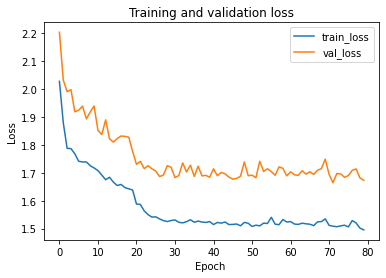

In [20]:
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.title("Training and validation loss")
plt.xlabel("Epoch ")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

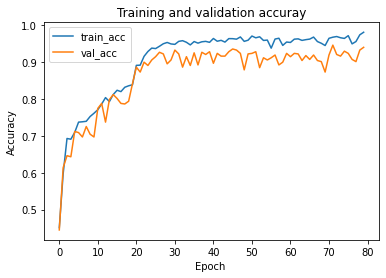

In [21]:
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.title("Training and validation accuray")
plt.xlabel("Epoch ")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

## 4. Evaluate the model

In [22]:
# define the function to evaluate the model
def evaluate(data_loader):
    # forbide the computation of grandient: autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        pred_targets = []
        for data, _ in tqdm(data_loader,  ascii ="  ...="):
            data = data.to(device)
            pred_target = model(data)
            pred_targets.extend(pred_target.argmax(axis=1).cpu().numpy())
    return pred_targets

In [23]:
# display metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
targets_hat = evaluate(test_loader)
print(classification_report(test_data.targets, np.array(targets_hat), target_names=test_data.classes))

100%|==========| 13/13 [00:03<00:00,  3.73it/s]

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.90      0.93      0.91        85
                        Tomato___Early_blight       0.75      0.80      0.77        81
                         Tomato___Late_blight       0.92      0.54      0.68        83
                           Tomato___Leaf_Mold       0.87      0.84      0.86        74
                  Tomato___Septoria_leaf_spot       0.72      0.92      0.81        86
Tomato___Spider_mites Two-spotted_spider_mite       0.88      0.84      0.86        83
                         Tomato___Target_Spot       0.81      0.70      0.75        77
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.84      0.95      0.89        77
                 Tomato___Tomato_mosaic_virus       0.86      1.00      0.93        81
                             Tomato___healthy       0.97      0.90      0.93        79

                                     accu

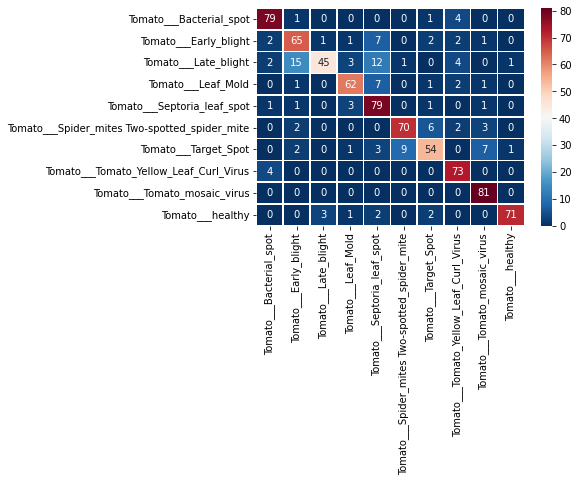

In [24]:
sns.heatmap(confusion_matrix(test_data.targets, targets_hat), 
             xticklabels=test_data.classes,
             yticklabels=test_data.classes,
             cmap='RdBu_r',
             annot=True,
             linewidth=0.5)